In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import glob
import os

from scipy.stats import trim_mean
from statsmodels import robust
from matplotlib import font_manager, rc
%matplotlib inline
from matplotlib import cm 

%matplotlib inline

# 한글 폰트 설정
import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
input_file = r'/content/drive/MyDrive/날씨 콘테스트/data' 

all_file_list = glob.glob(os.path.join(input_file, 'buy*'))
all_data = [] 

for file in all_file_list:
    df = pd.read_csv(file) 
    df.columns = ['num','data','sex','age','big_cat','sm_cat','qty']
    all_data.append(df)
    
buy_data = pd.concat(all_data, axis=0, ignore_index=True)

In [5]:
buy_data['year'] = buy_data['data'].astype('str').astype('datetime64').dt.year
buy_data['month'] = buy_data['data'].astype('str').astype('datetime64').dt.month
buy_data['day'] = buy_data['data'].astype('str').astype('datetime64').dt.day
buy_data['Day_of_week'] = (buy_data['data'].astype('str').astype('datetime64').
                           apply(lambda x: ('월','화','수','목','금','토','일')[x.weekday()]))
buy_data['week'] = buy_data['data'].astype('str').astype('datetime64').dt.week

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [6]:
buy_data['date'] = buy_data['data'].astype('str').astype('datetime64')

# sm_cat을 구매 빈도에 따라 세 그룹으로 분류(필요없음)

In [7]:
buy_mean = buy_data.groupby(['sm_cat'])['qty'].mean().fillna(0)
buy_mean = pd.DataFrame(buy_mean).sort_values(by='qty',ascending = False)

In [3]:
plt.figure(figsize = (15, 50))
sns.barplot(y=buy_mean.index, x='qty', data = buy_mean, orient = 'h')
plt.title('중분류 구매수량 중위값')
plt.show()

NameError: name 'plt' is not defined

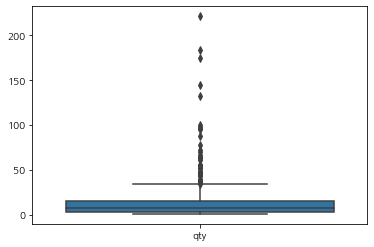

In [ ]:
sns.boxplot(data=buy_mean)

In [9]:
def extract_outlier(df, col):
  fraud_col_data = df[col]

  highest = np.percentile(fraud_col_data,95)
  highest_index = fraud_col_data[fraud_col_data > highest].index
  highest_df = df.loc[highest_index,:]
  normal_df = df.drop(highest_index,axis=0)
  print(highest)
  return normal_df, highest_df

In [10]:
normal_buy, high_buy = extract_outlier(buy_mean,'qty')

55.69528696364093


너무 빈도수가 높거나 적은 것은 제외

In [11]:
normal = normal_buy.index
high = high_buy.index

In [12]:
normal, high

(Index(['홍삼액/홍삼정', '기초 화장용 스킨', '닭가슴살', '클렌징 폼', '트리트먼트', '베이스 메이크업용 파운데이션',
        '기초 화장용 로션', '바디 보습제', '기능성 아이케어 화장품', '색조 메이크업 립스틱',
        ...
        '마/야콘', '중대형 에어컨', '에어커튼', '가스온수기', '산림욕기', '색조 메이크업 세트', '향수세트',
        '남성향수', '과일채소 분말/분태', '여성향수'],
       dtype='object', name='sm_cat', length=363),
 Index(['기초 화장용 크림', '생수', '커피음료', '샴푸', '회', '기초 화장용 에센스', '돼지 곱창', '쌀',
        '인스턴트커피', '두유', '감귤/한라봉/오렌지', '비타민', '스킨케어 마스크팩', '흰우유', '네일 메이크업 용품',
        '프로바이오틱스', '카페 푸드', '탄산음료', '다이어트보조식', '베이스 메이크업용 쿠션팩트'],
       dtype='object', name='sm_cat'))

# 소분류 카테고리 구매 패턴 분석 - 주별

In [59]:
buy_grp = buy_data.groupby(['sm_cat','date'])['qty'].mean().reset_index().set_index('sm_cat')

In [52]:
normal_buy_date = buy_grp.loc[normal_buy.index,:]
high_buy_date = buy_grp.loc[high_buy.index,:]

In [64]:
def time_cat_line(lv):
  temp = buy_grp.loc[lv,:]
  for cat in lv:
    t = temp.loc[cat,:]
    t = pd.pivot_table(t, index= 'date', values = 'qty')
    t = t/t.sum(axis=0)
    plt.figure(figsize = (15, 6))
    sns.lineplot(y='qty', x=t.index, data = t)
    plt.title("{} 구매 흐름".format(cat))
    plt.show()

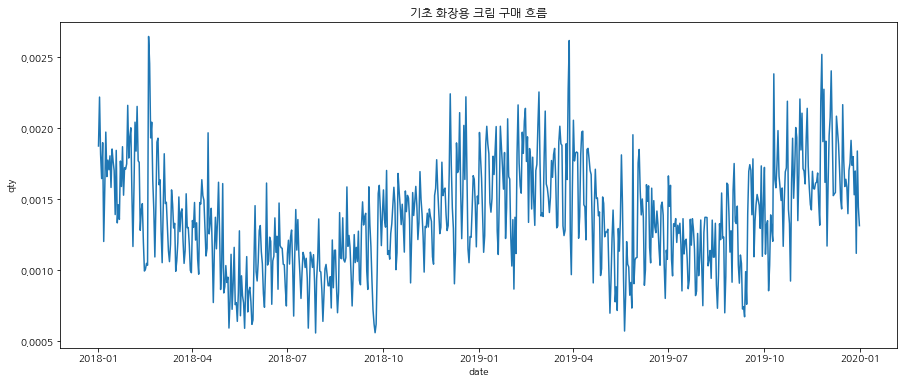

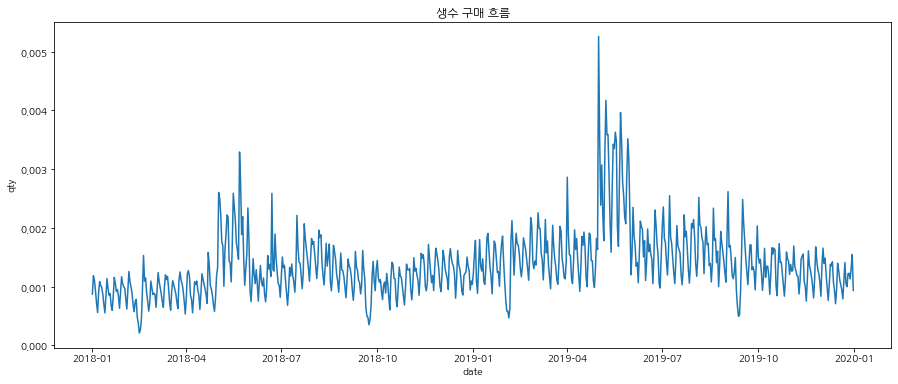

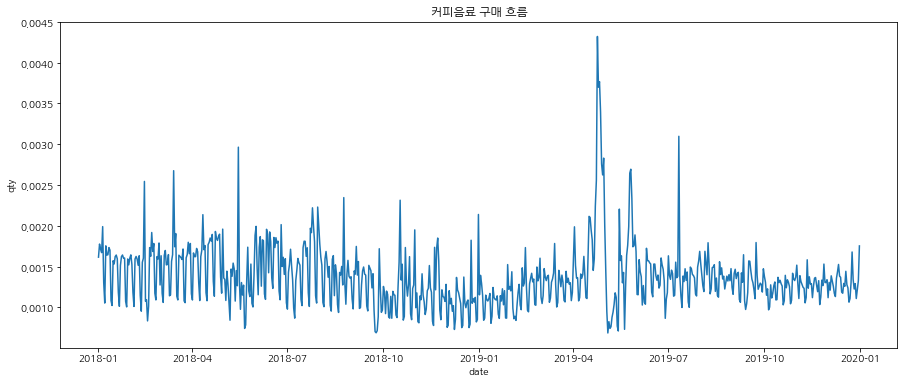

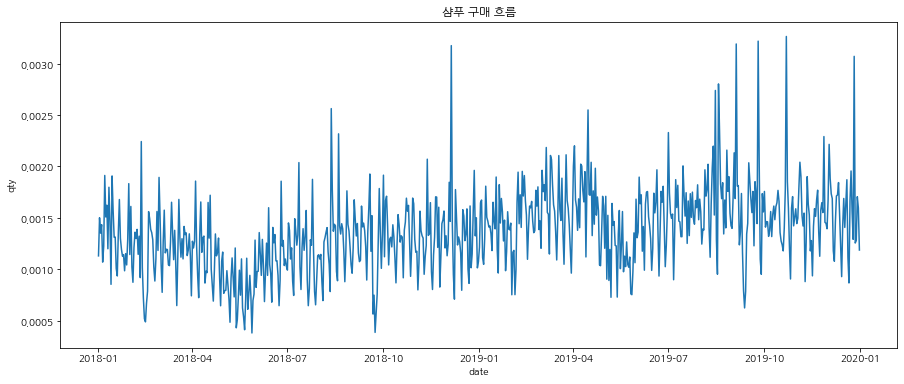

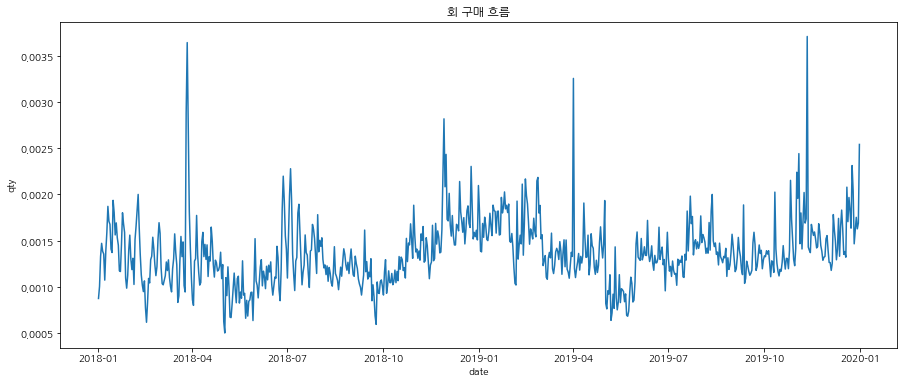

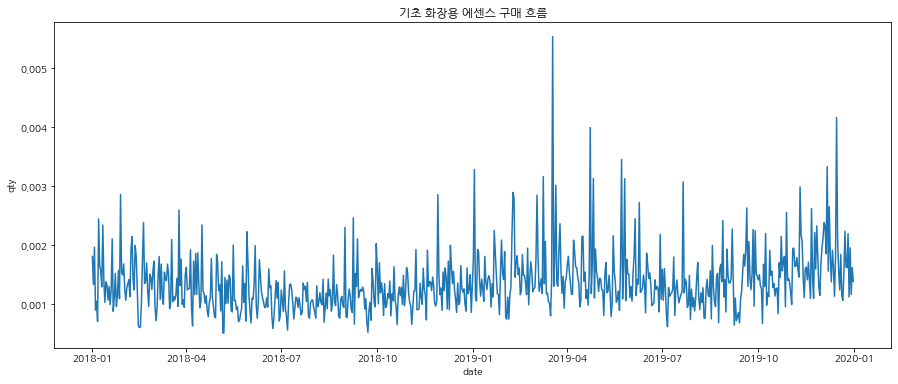

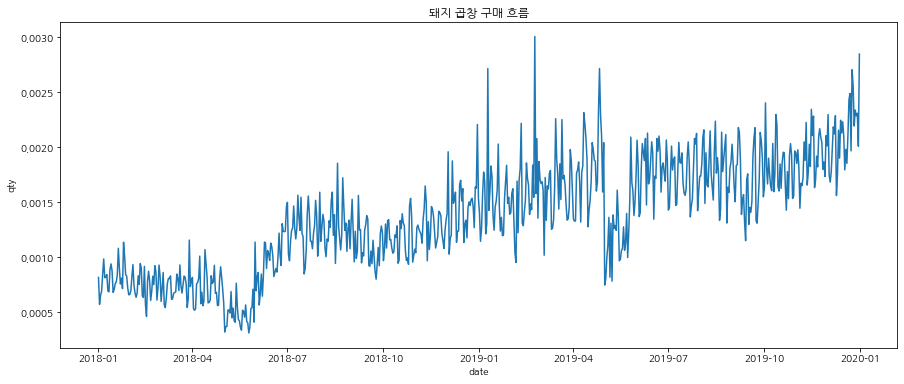

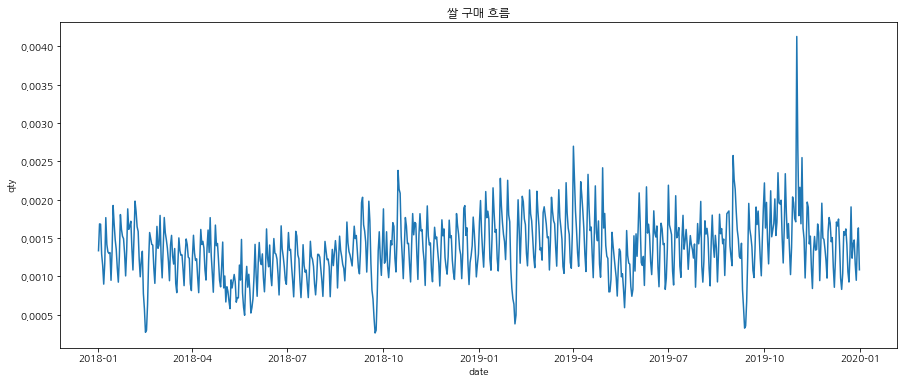

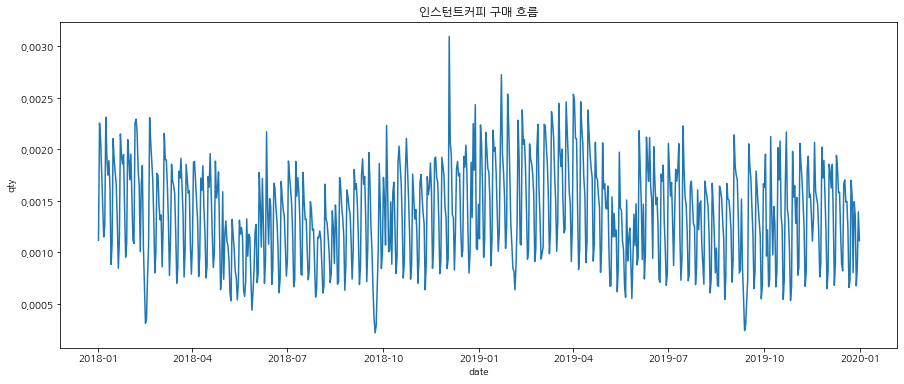

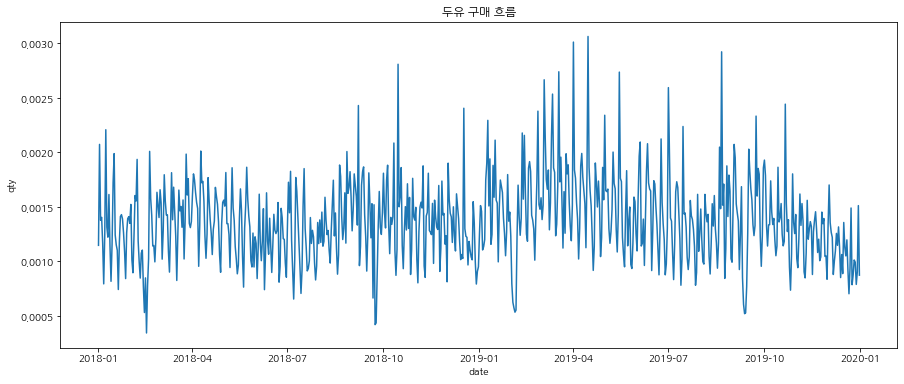

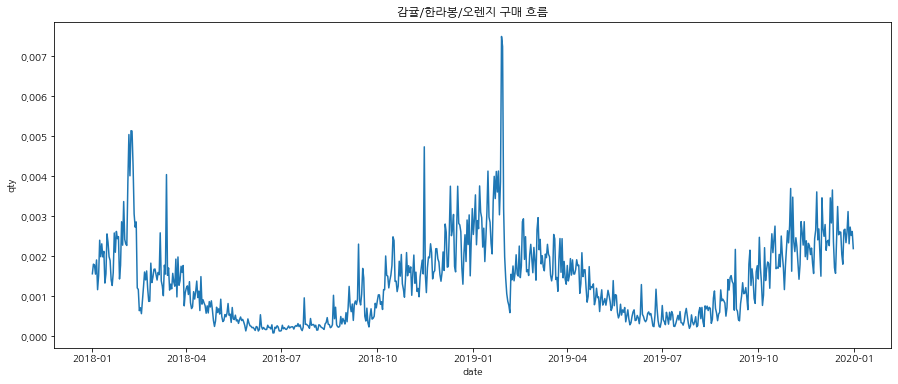

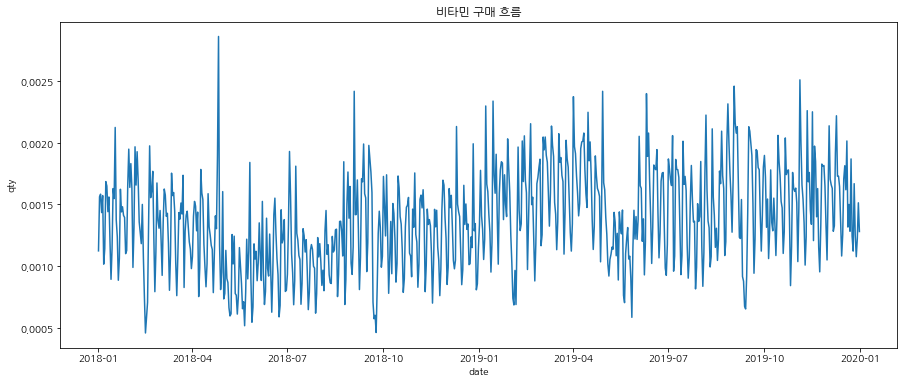

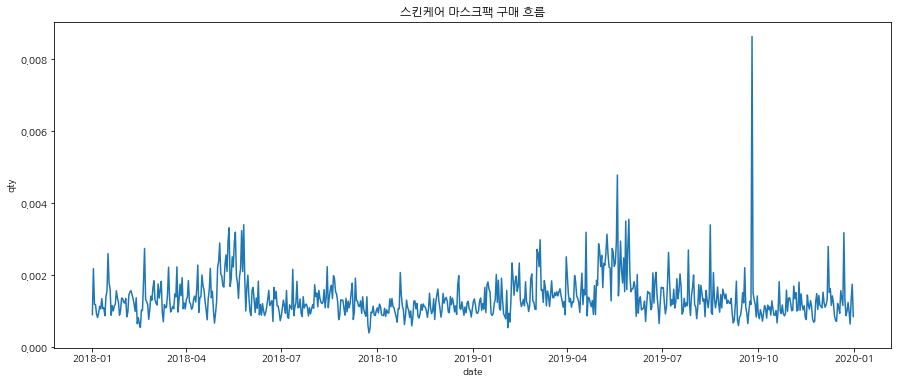

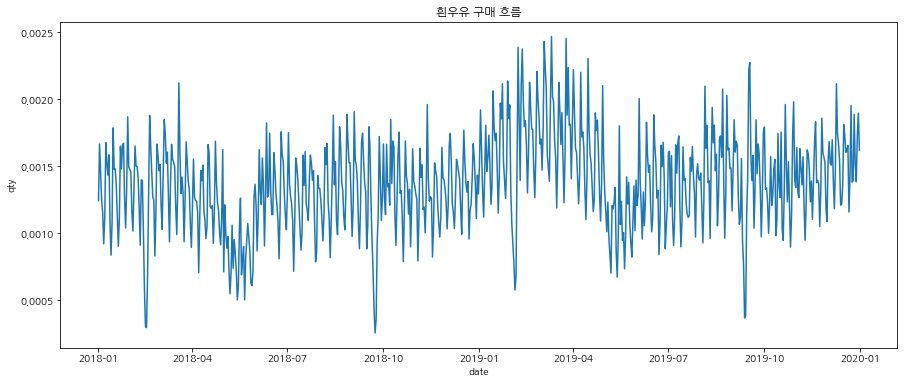

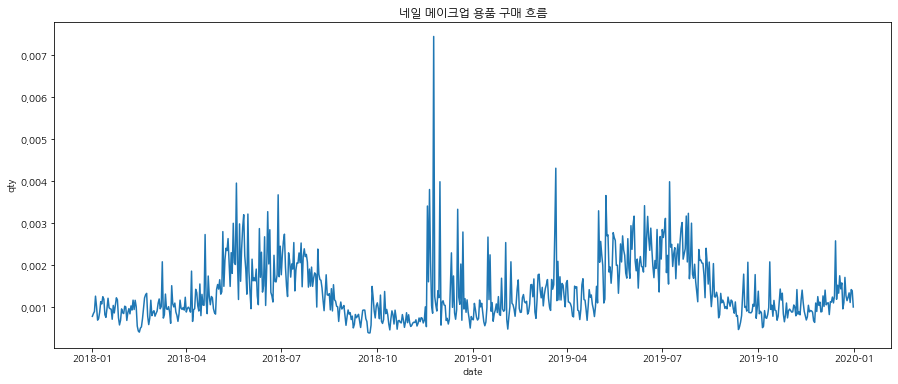

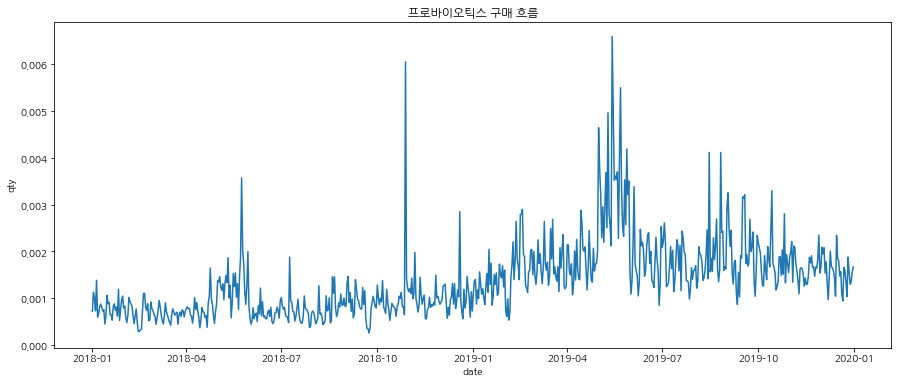

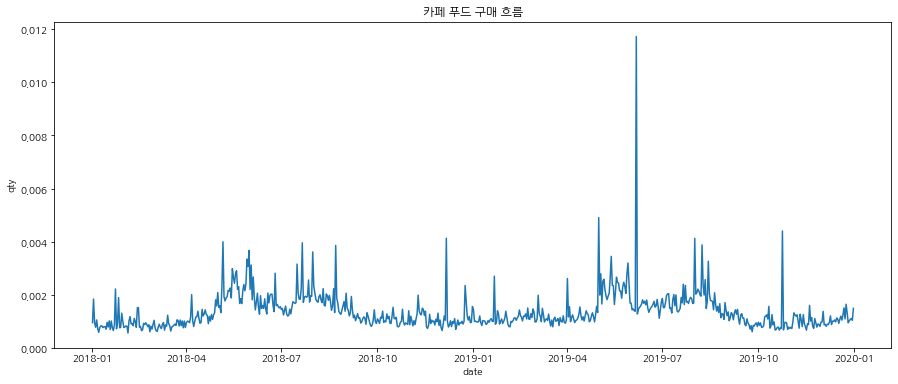

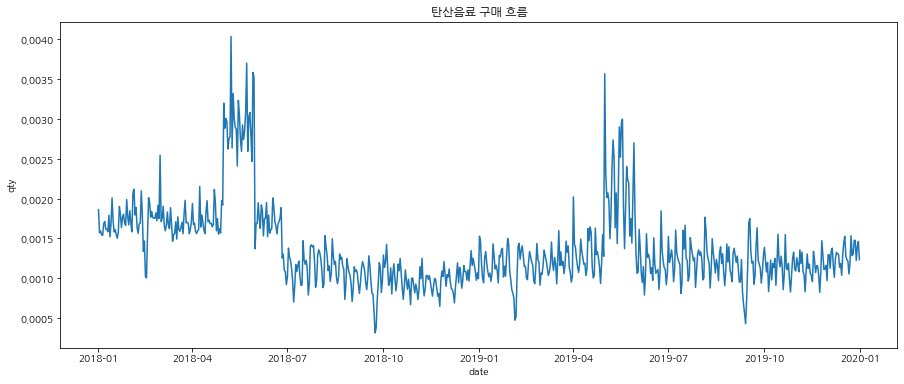

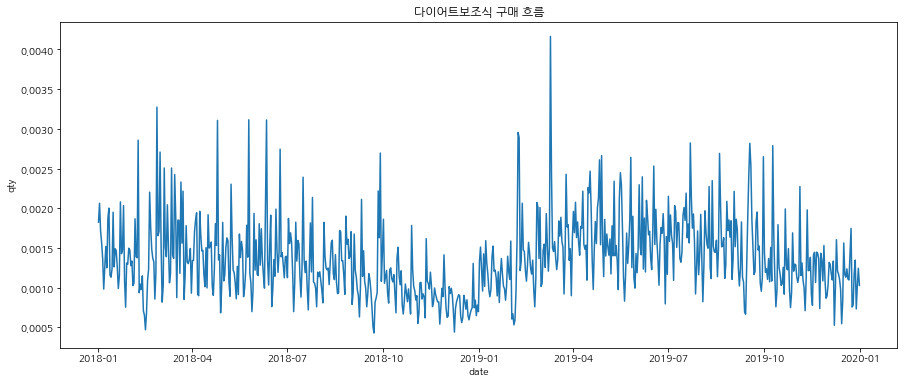

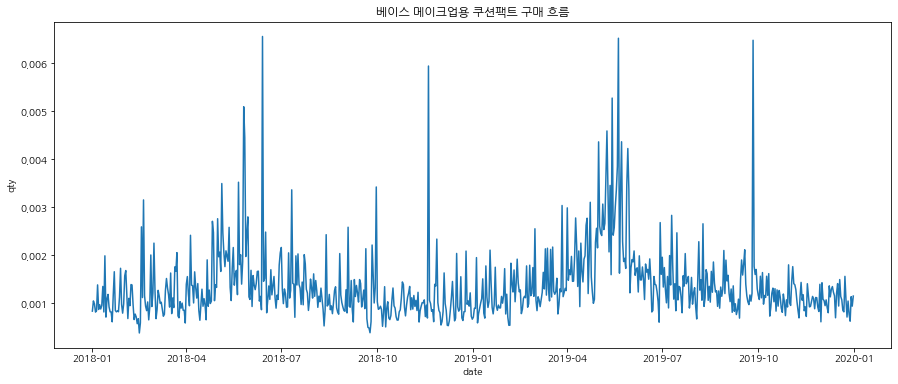

In [65]:
time_cat_line(high)

## 클러스터링

In [17]:
sm_date_qty = pd.pivot_table(buy_grp, index='sm_cat', columns='week',values = 'qty', aggfunc = 'mean').fillna(0)
sm_date_qty = sm_date_qty/sm_date_qty.sum(axis=0)
sm_date_qty

week,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52
sm_cat,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
가공란,0.003230,0.003507,0.003603,0.002606,0.002612,0.002386,0.003286,0.004112,0.003825,0.003833,0.004281,0.004424,0.004243,0.003329,0.003319,0.004862,0.003784,0.003111,0.002973,0.004206,0.003183,0.003796,0.003569,0.004094,0.003556,0.003922,0.003220,0.003098,0.002904,0.003053,0.002628,0.003166,0.004103,0.003483,0.004561,0.003142,0.002427,0.002862,0.002902,0.003082,0.002754,0.003135,0.002967,0.003553,0.003250,0.003276,0.003401,0.003829,0.003065,0.002855,0.002987,0.003802
가스온수기,0.000001,0.000005,0.000008,0.000000,0.000006,0.000006,0.000004,0.000001,0.000005,0.000006,0.000005,0.000001,0.000001,0.000003,0.000003,0.000003,0.000000,0.000002,0.000004,0.000002,0.000000,0.000001,0.000000,0.000003,0.000005,0.000000,0.000003,0.000000,0.000005,0.000001,0.000001,0.000003,0.000004,0.000003,0.000004,0.000004,0.000002,0.000006,0.000010,0.000001,0.000004,0.000007,0.000007,0.000009,0.000007,0.000008,0.000005,0.000009,0.000004,0.000005,0.000009,0.000001
가열식 가습기,0.000336,0.000267,0.000149,0.000149,0.000148,0.000118,0.000157,0.000124,0.000060,0.000050,0.000038,0.000047,0.000041,0.000032,0.000032,0.000031,0.000020,0.000029,0.000038,0.000035,0.000020,0.000012,0.000004,0.000003,0.000007,0.000006,0.000005,0.000004,0.000014,0.000025,0.000017,0.000006,0.000006,0.000011,0.000027,0.000013,0.000041,0.000082,0.000123,0.000095,0.000169,0.000250,0.000181,0.000363,0.000288,0.000322,0.000409,0.000348,0.000544,0.000492,0.000374,0.000341
가자미,0.000495,0.000595,0.000552,0.000595,0.000424,0.000561,0.000320,0.000398,0.000646,0.000638,0.000692,0.000649,0.000456,0.000776,0.000451,0.000597,0.000532,0.000651,0.000413,0.000541,0.000442,0.000355,0.000485,0.000379,0.000498,0.000410,0.000462,0.000360,0.000459,0.000283,0.000400,0.000471,0.000441,0.000529,0.000499,0.000639,0.000487,0.000352,0.000278,0.000380,0.000516,0.000450,0.000519,0.000571,0.000457,0.000466,0.000418,0.000428,0.000557,0.000483,0.000499,0.000514
갈비/찜/바비큐용 돈육,0.000311,0.000307,0.000283,0.000270,0.000248,0.000305,0.000259,0.000244,0.000263,0.000225,0.000305,0.000354,0.000249,0.000392,0.000255,0.000237,0.000310,0.000361,0.000257,0.000256,0.000308,0.000287,0.000282,0.000303,0.000332,0.000413,0.000329,0.000384,0.000397,0.000449,0.000465,0.000437,0.000457,0.000532,0.000427,0.000442,0.000545,0.000448,0.000317,0.000315,0.000366,0.000353,0.000343,0.000301,0.000339,0.000338,0.000390,0.000362,0.000400,0.000377,0.000455,0.000433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
황토매트,0.000175,0.000145,0.000133,0.000168,0.000123,0.000161,0.000122,0.000094,0.000085,0.000081,0.000086,0.000109,0.000064,0.000076,0.000074,0.000067,0.000055,0.000070,0.000075,0.000062,0.000051,0.000045,0.000020,0.000018,0.000017,0.000008,0.000020,0.000019,0.000022,0.000004,0.000017,0.000012,0.000017,0.000019,0.000044,0.000077,0.000095,0.000187,0.000401,0.000298,0.000535,0.000475,0.000331,0.000343,0.000314,0.000337,0.000332,0.000272,0.000269,0.000255,0.000188,0.000186
회,0.028242,0.028405,0.029077,0.026613,0.024410,0.025374,0.027070,0.025696,0.027044,0.020416,0.022381,0.022812,0.029240,0.024079,0.024020,0.023394,0.022587,0.016690,0.014918,0.015948,0.014148,0.019991,0.022760,0.023173,0.022204,0.027279,0.025840,0.024466,0.024559,0.028702,0.029147,0.024803,0.025025,0.024094,0.022563,0.020338,0.024890,0.022070,0.022862,0.023640,0.023963,0.022842,0.026781,0.028335,0.027914,0.028370,0.026959,0.030758,0.026296,0.028694,0.030174,0.031873
휴대용 선풍기,0.000092,0.000059,0.000044,0.000075,0.000048,0.000059,0.000087,0.000073,0.000093,0.000120,0.000169,0.000233,0.000369,0.000589,0.000463,0.000781,0.001590,0.001200,0.000849,0.001177,0.002731,0.003853,0.005439,0.003811,0.004027,0.004315,0.004832,0.004557

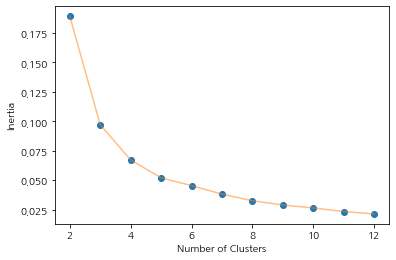

<Figure size 720x720 with 0 Axes>

In [18]:
from sklearn.cluster import KMeans
n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
inertia = []

for n_cluster in n_clusters:
  kmeans = KMeans(n_clusters=n_cluster)
  kmeans.fit(sm_date_qty)
  inertia.append(kmeans.inertia_) #Inertia can be recognized as a measure of how internally coherent clusters are.

plt.plot(n_clusters, inertia, 'o')
plt.plot(n_clusters, inertia, '-', alpha = 0.5)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.figure(figsize = (10, 10))
plt.tight_layout()
plt.show()

In [33]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(sm_date_qty)

cls = pd.DataFrame({'cls':kmeans.labels_}).set_index(sm_date_qty.index)
#buy_mean['cls'] = kmeans.labels_

In [34]:
cls.loc[cluster.cls == 1].index

Index(['가공란', '감자', '건어물 마른오징어', '견과류', '계란', '고등어', '공기정화 용품', '공기청정기', '과일류',
       '과채 음료/주스', '기능성 아이케어 화장품', '기초 화장용 로션', '기초 화장용 미스트', '기초 화장용 오일/앰플',
       '기타 주스류', '김치류', '루테인/눈 영양제', '메이크업 브러쉬', '무김치', '밀크티/티라떼',
       '바나나/파인애플/망고', '바디 보습제', '바디 클렌져', '배/포도/과일즙', '배추김치',
       '베이스 메이크업용 파우더팩트', '베이스 메이크업용 파운데이션', '복분자/석류/과실즙', '색조 메이크업 립밤',
       '색조 메이크업 립스틱', '색조 메이크업 립틴트', '색조 메이크업 아이라이너', '색조 메이크업 아이브로우',
       '색조 메이크업 아이섀도우', '선케어용 선밤', '선크림', '소고기 육회', '수산 생물', '스크럽/필링크림',
       '스킨케어 시트마스크팩', '스킨케어 코팩', '야채/호박즙', '오리고기/훈제오리', '오메가3/스쿠알렌 영양제',
       '온열매트', '요거트/발효유', '원두커피', '유제품 음료', '잡곡', '전통차', '조개', '참외/메론/수박',
       '칼슘/철분 영양제', '캡슐/POD커피', '콜라겐/코큐텐 영양제', '클렌징 오일', '탄산수', '토마토', '트리트먼트',
       '파/양파', '한방 분말/환제품', '한우육', '핸드크림', '허브차', '헤어스타일링용 염색약', '헤어에센스',
       '화장 비누'],
      dtype='object', name='sm_cat')

In [48]:
def time_cat_cluster(cls_l):
    temp = cls.loc[cls.cls == cls_l]
    for c in temp.index:
      cat = buy_grp.loc[c]
      temp1 = pd.pivot_table(cat, index= 'week', values = 'qty', aggfunc = 'mean')
      temp1 = temp1/temp1.sum(axis=0)
      plt.figure(figsize = (15, 6))
      sns.lineplot(y='qty', x=temp1.index, data = temp1)
      plt.title("clster {}: {} 구매 흐름".format(cls_l,c))
      plt.show()

In [49]:
for i in range(cls.cls.nunique()):
  time_cat_cluster(1)

Output hidden; open in https://colab.research.google.com to view.

## high

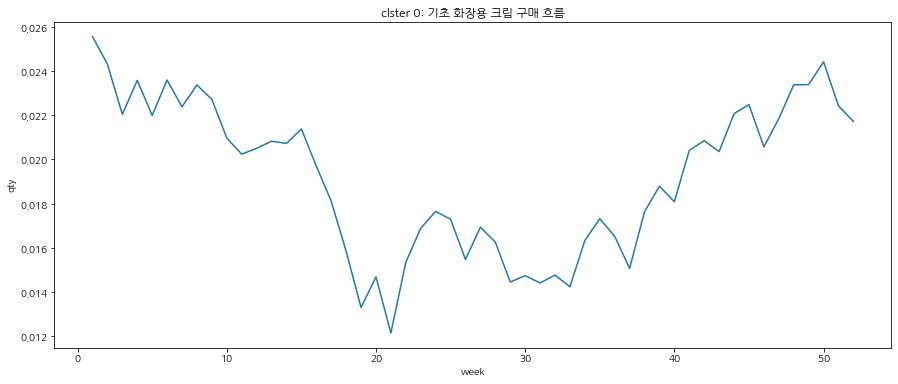

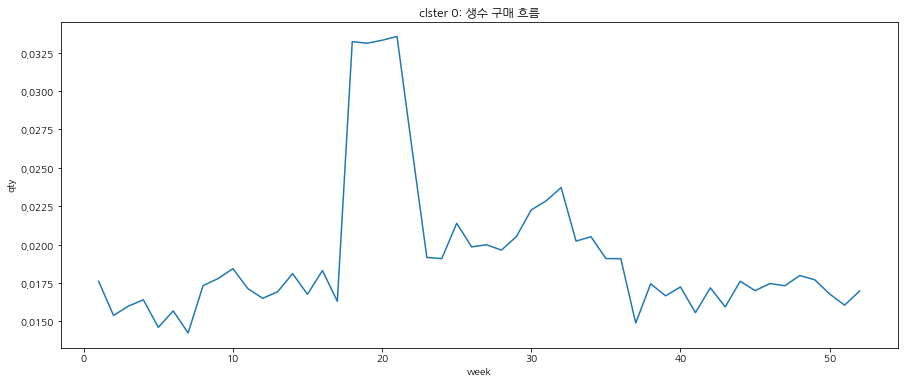

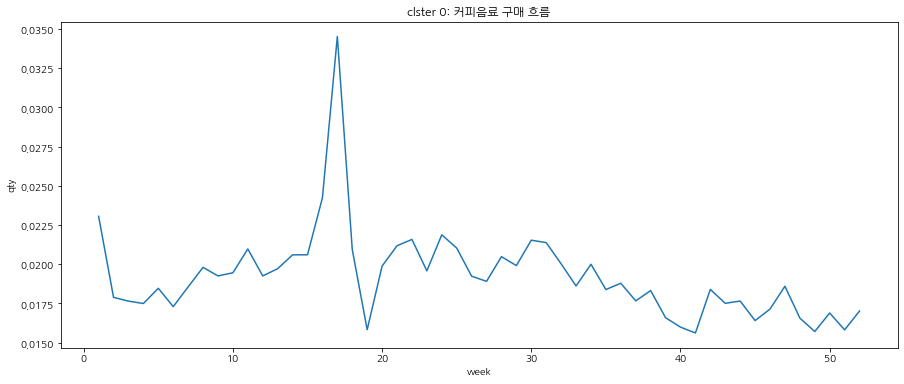

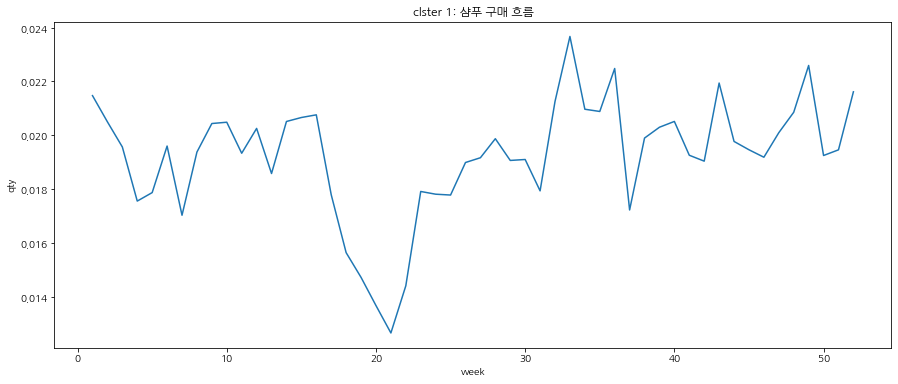

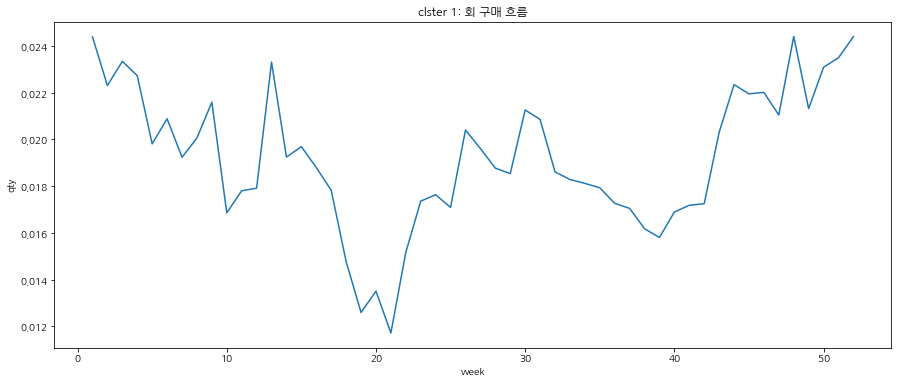

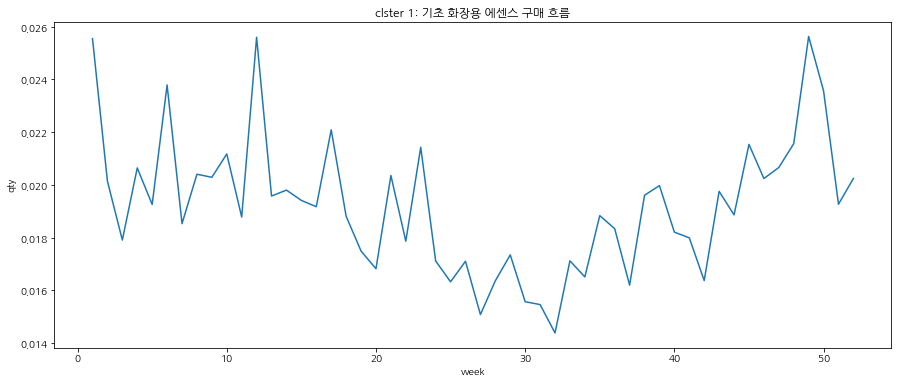

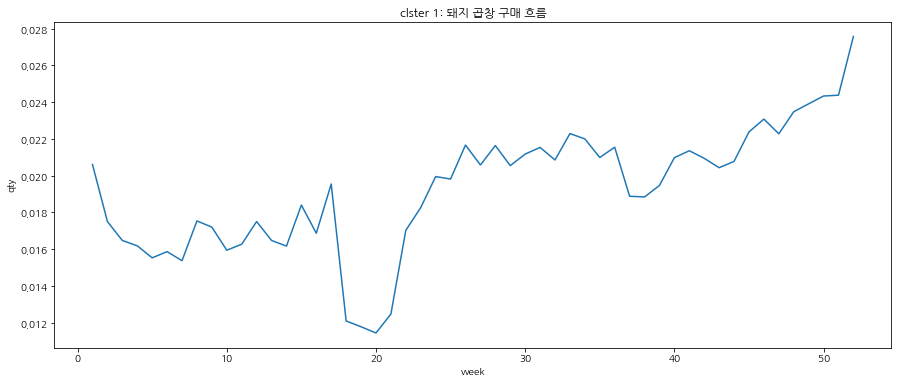

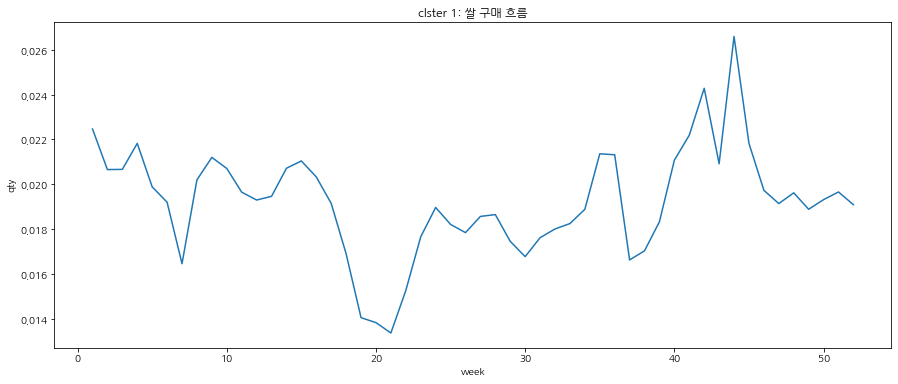

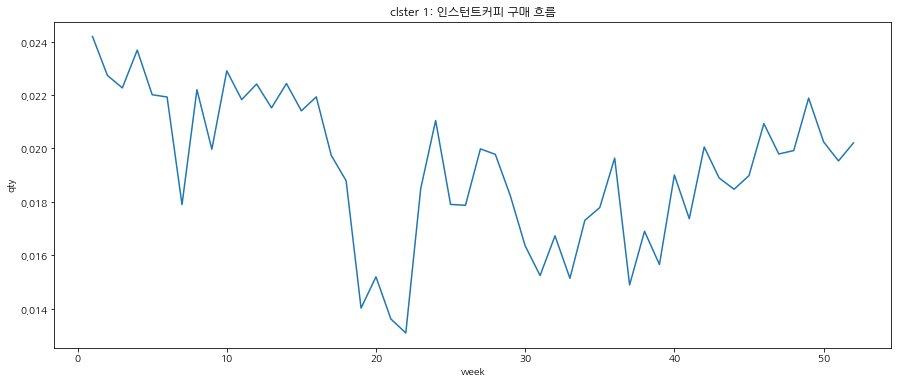

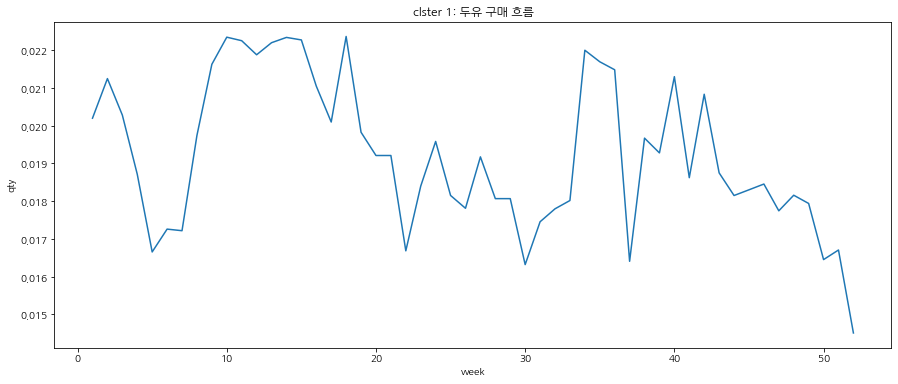

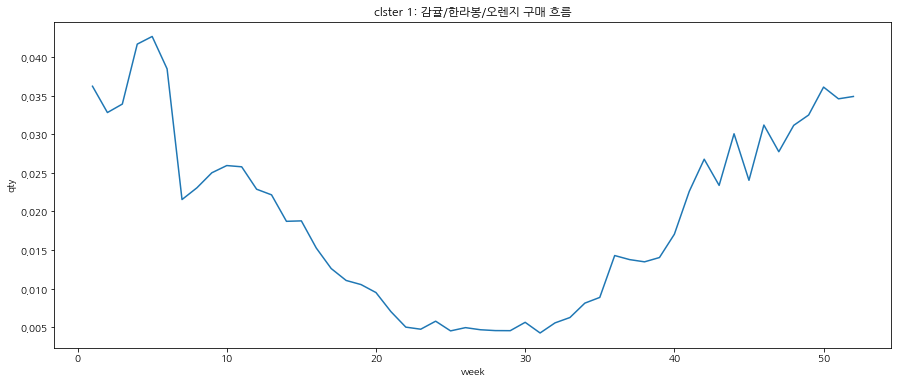

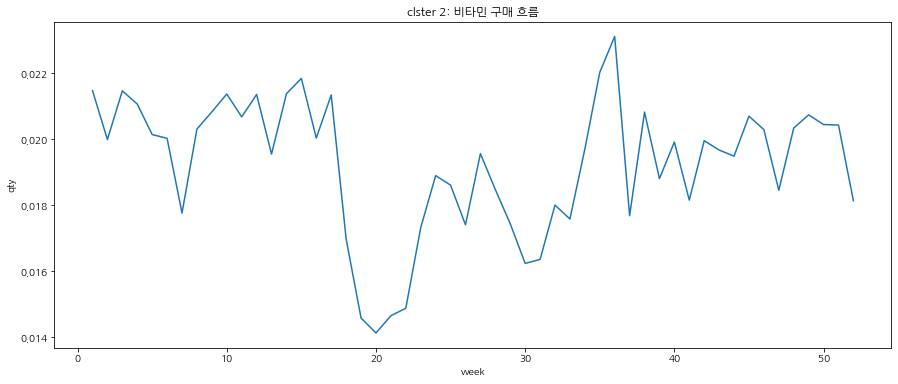

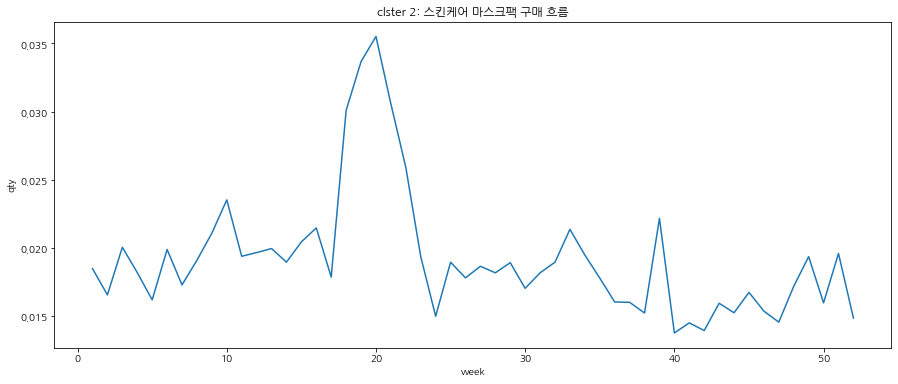

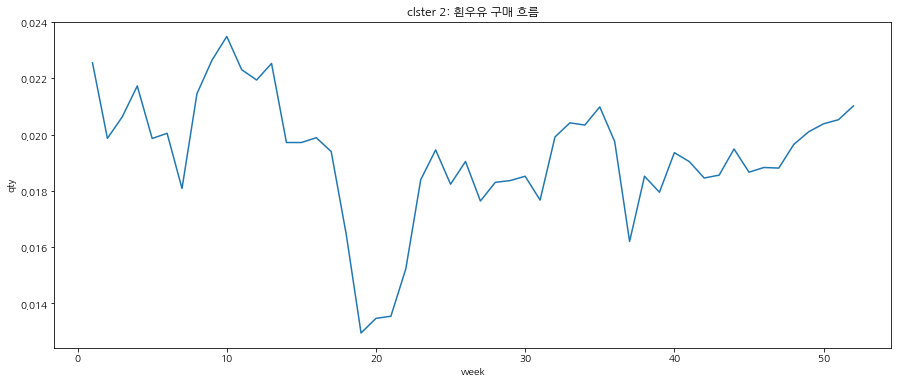

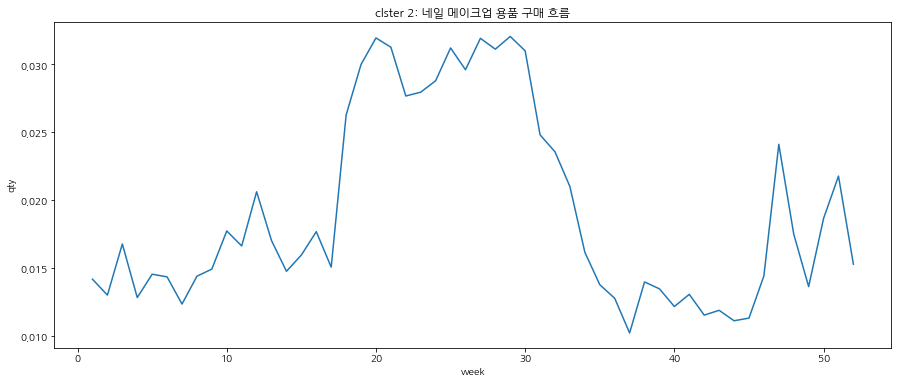

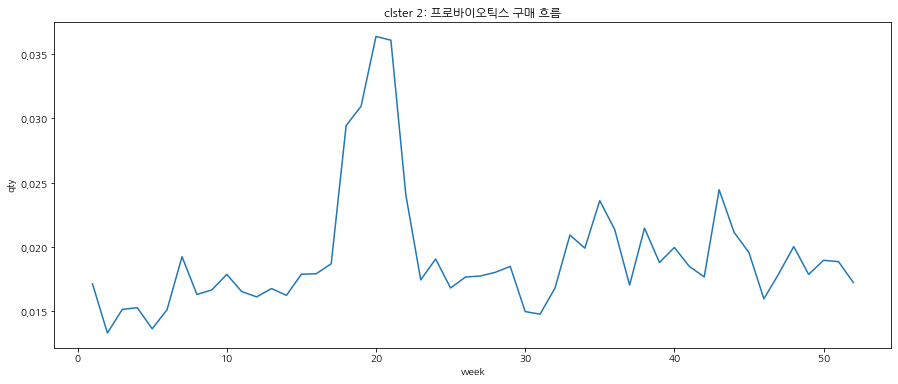

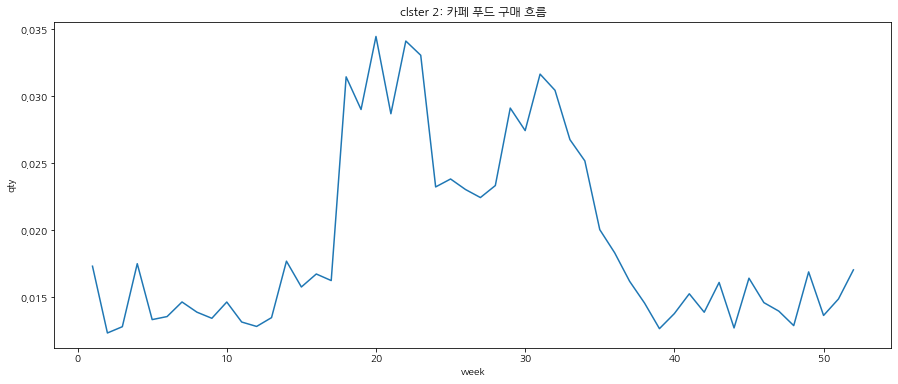

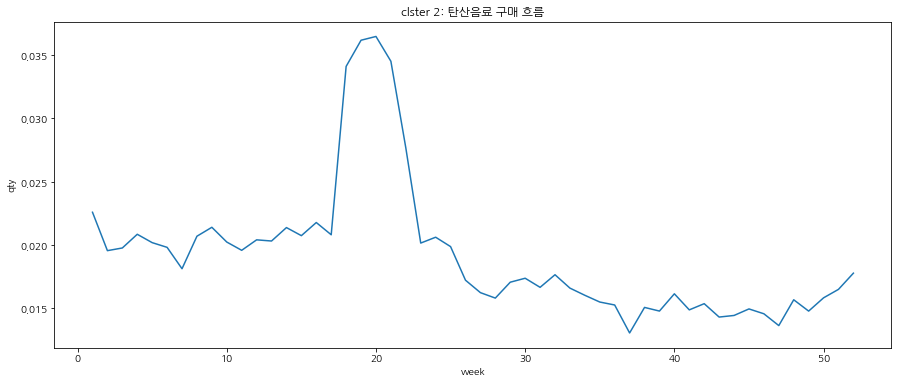

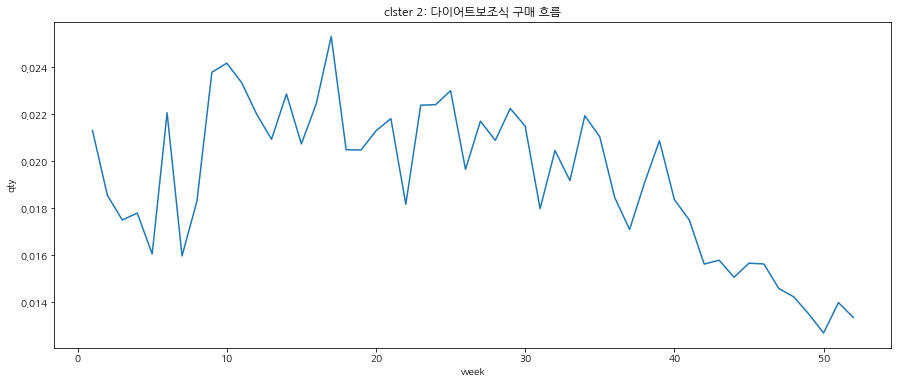

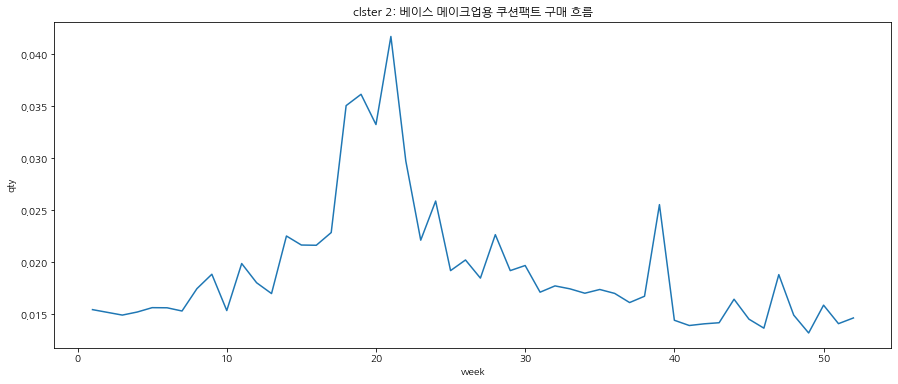

In [ ]:
time_cat_cluster(high_buy)

## normal

In [ ]:
time_cat_cluster(normal_buy)

Output hidden; open in https://colab.research.google.com to view.